In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from google.colab.patches import cv2_imshow
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
fcn = models.segmentation.fcn_resnet101(weights=models.segmentation.FCN_ResNet101_Weights.DEFAULT).eval()
deeplab = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:01<00:00, 136MB/s]
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 155MB/s]


In [4]:
def process(path):
  img = Image.open(path).convert('RGB')
  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
  img = transform(img)
  img = img.unsqueeze(0)
  return img

In [5]:
def segment(path):
  img_tensor = process(path)
  with torch.no_grad():
    fcn_output = fcn(img_tensor)['out'][0]
    deeplab_output = deeplab(img_tensor)['out'][0]

#  result of model   {
#   'out': tensor of shape [1, C, H, W]
# }

# fcn(img_tensor) returns a dictionary with key 'out' that contains the segmentation output tensor of shape [1, C, H, W].
# ['out'] accesses the actual output tensor (class score maps for each pixel).
# [0] removes the batch dimension (since batch size = 1), resulting in shape [C, H, W] so you can apply .argmax(0) to get the final segmentation mask.



  fcn_mask = fcn_output.argmax(0).byte().cpu().numpy()
  deeplab_mask = deeplab_output.argmax(0).byte().cpu().numpy()


# .argmax(0) finds the class with the highest score at each pixel (across channels), giving a [H, W] mask of class indices.
# .byte() converts the data type to 8-bit unsigned integers (uint8), which is required for many image operations like color mapping with OpenCV.
# .cpu().numpy() moves the tensor to CPU and converts it to a NumPy array for visualization or further processing


  original = cv2.imread(path)
  original = cv2.resize(original, (224, 224))

  fcn_color = cv2.applyColorMap((fcn_mask*10).astype(np.uint8), cv2.COLORMAP_JET)
  deeplab_color = cv2.applyColorMap((deeplab_mask * 10).astype(np.uint8), cv2.COLORMAP_JET)


# fcn_mask * 10 amplifies class indices to spread them across a visible color range (since class values like 1, 2, 3 are too low for color maps).
# .astype(np.uint8) converts the mask to 8-bit format, which is required by OpenCV's applyColorMap().
# cv2.applyColorMap(..., cv2.COLORMAP_JET) applies the JET colormap to visualize the segmentation mask in vibrant colors.

  combined = np.hstack((original, fcn_color, deeplab_color))
  cv2_imshow(combined)

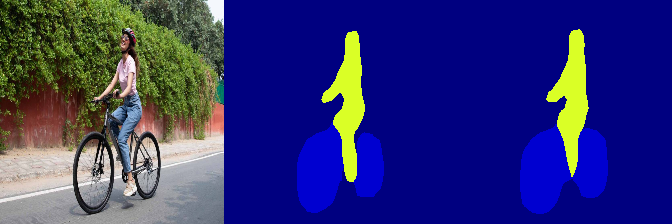

In [6]:
segment("/content/drive/My Drive/bicycle.jpg")